# Meta Learning Tutorial with the Omniglot Dataset

In [56]:
import functools

import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import optax

import haiku as hk

from tensorflow_probability.substrates import jax as tfp

import omniglot_dataset
import maml
import nets

tfd = tfp.distributions

## Explore the Omniglot fataset a bit

Plotting and exploration based on https://github.com/LecJackS/CS-330-Deep-Multi-Task-and-Meta-Learning/blob/master/hw1/%5BOLD%5DHomework%201%20-%20Step%20by%20step.ipynb

In [47]:
num_classes = 5
num_samples_per_class = 1
omniglot = omniglot_dataset.Omniglot(32, num_classes, num_samples_per_class)

support, query = next(omniglot.train_set)

In [48]:
def plot_example(images, labels):
    plt.figure(figsize=(16, 10))
    count = 0
    for cl in range(images.shape[2]):
        for sa in range(images.shape[1]):
            plt.subplot(num_samples_per_class, num_classes, count + 1)
            plt.title("Class {}\nExample {}\nLabel {}".format(cl, sa, labels[0, sa, cl]))
            image = images[0, sa, cl].reshape((28,28))
            plt.imshow(image, cmap='Greys')
            plt.axis('off');
            count += 1

Plot of an example support set

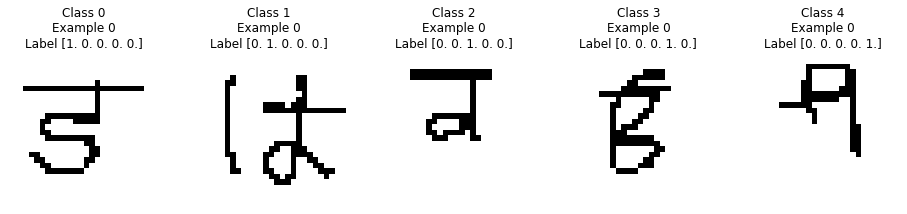

In [49]:
plot_example(*support)

Plot it's corresponding query set

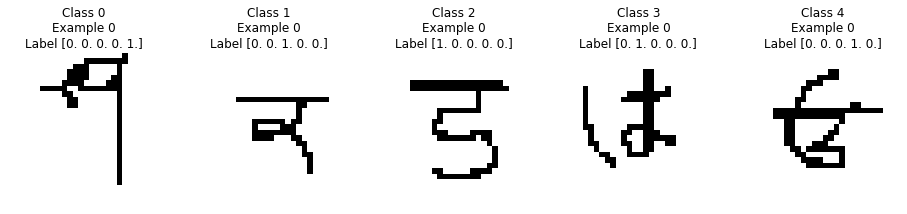

In [50]:
plot_example(*query)

Seems like the query and support sets labels match so everything is good with the data generator!

## Defining a training loop

In [59]:
@functools.partial(jax.jit, static_argnums=[0, 1])
def update(model, optimizer, prior_params, opt_state, support, query):
    grads = model.update_step(prior_params, support, query)
    updates, new_opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state
    

def train(model, data):
    eval_losses = []
    opt = optax.flatten(optax.adam(1e-3))
    opt_state = opt.init(model.prior_params)
    for step in range(20000):
        model.prior_params, opt_state = update(model, model.prior_params, opt_state, *next(data.train_set))
        if step % 100 == 0:
            eval_support, eval_query = next(data.eval_set)
            posterior_params = model.adaptation_step(model.prior_params, *eval_support)
            loss = -model(evel_qeury[0]).log_prob(eval_query[1])
            eval_loss.append(loss)
    return eval_losses
            


## Train MAML

In [60]:
def net(x):
    def cnn(x):
        x = nets.cnn(x, depth=32, kernels=(4, 4, 4))
        logits = hk.Linear(num_classes)(x)
        return logits
    cnn = hk.BatchApply(cnn, 2)
    logits = cnn(x)
    return tfd.Independent(tfd.Categorial(logits), 1)
model = maml.Maml(hk.BatchApply(net, 3), support[0], 0.4)

eval_losses = train(model, omniglot)

InconclusiveDimensionOperation: Cannot divide evenly the sizes of shapes (558, 1, 5) and (160, 28, 1, 5)